<a href="https://colab.research.google.com/github/Masoomas98/DSPS_MSarfraz/blob/main/Homeworks/%20HMW_10/HMW10_PINN_Burgers_tofillinipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
tf.__version__

'2.14.0'

In [2]:
import scipy
from scipy import io
from scipy.interpolate import griddata
import pylab as pl
import matplotlib.pyplot as plt

In [3]:
!wget https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat

--2023-12-11 23:56:07--  https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat [following]
--2023-12-11 23:56:07--  https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 207944 (203K) [application/octet-stream]
Saving to: ‘burgers_shock.mat’

burgers_shock.mat   100%[===================>] 203.07K  --.-KB/s    in 0.02s   

2023-12-11 23:56:07 (8.19 MB/s) - ‘burgers_shock.mat’ saved

(100,) (256,) (256, 100)


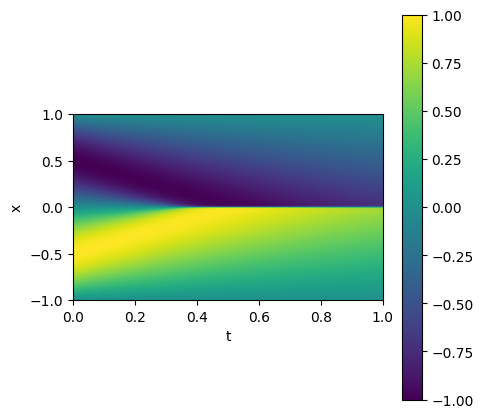

In [4]:
### what is the solution that we want? read in the data

# loading in a file saved as a binary (?) in mathematica
data = scipy.io.loadmat('burgers_shock.mat')

data.keys()

t = data['t'].flatten() #time
x = data['x'].flatten() #position
Z = np.real(data['usol']) #solution of Burger's Ee

print(t.shape, x.shape, Z.shape)

ax = pl.figure(figsize=(5,5)).add_subplot(111)
cb = ax.imshow(Z[::-1],extent=[0,1,-1,1], clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3)
pl.colorbar(cb);


Figure 1: This figure depicts the solution of Burger's equation and we will try to get the similar solution using neural network by classifying 10000 points within the boundary defined.

# PROBLEM SETUP: BURGER'S EQUATIONS
$$
\begin{align}
    \partial_t u (t,x) + \mathcal{N}[u](t,x) &= 0, && (t,x) \in (0,T] \times \mathcal{D},\\
    u(0,x) &= u_0(x) \quad && x \in \mathcal{D},
\end{align}
$$


$$
\begin{align}
        \hspace{7em} u(t,x) &= u_b(t,x)  && \quad (t,x) \in (0,T] \times \partial \mathcal{D},
\end{align}
$$


# SPECIFIC CASE: LIMIT REGIME AND SET VISCOSITY TO $\nu=0.01/\pi$

$$
\begin{aligned}
    \partial_t u + u \, \partial_x u - (0.01/\pi) \, \partial_{xx} u &= 0, \quad &&\quad (t,x) \in (0,1] \times (-1,1),&&\mathrm{eq.1}\\
   u(0,x) &= - \sin(\pi \, x),                 \quad &&\quad x \in [-1,1],&\mathrm{eq.2}\\
   u(t,-1) = u(t,1) &= 0,                      \quad &&\quad t \in (0,1].
\end{aligned}
$$

In [5]:
tf.random.set_seed(123)
pi = tf.constant(np.pi, dtype="float32")

In [6]:
def fun_u_0(x): #u(0,x) eq 2
  return -tf.sin(pi * x)

def fun_u_b(t, x): #u(t,x) - set up container
  return tf.zeros((x.shape[0], 1), dtype="float32")

def fun_res(u, u_t, u_x, u_xx): #deruvatuve equation eq 1 - u_. is the derivative w respect to .
  return tf.abs(u_t + u * u_x - 0.01 / pi * u_xx)

In [7]:
#number of points we are using for training and predicting
n_0 = 50 #points at t=0 -> initial conditions
n_b = 50 #points at b=1;-1] -> boundary conditions
n_r = 10000

#boundaries
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.

# get random data in x at t=0


In [8]:
t_0 = tf.ones((n_0, 1), dtype="float32") * tmin
x_0 = tf.random.uniform((n_0, 1), xmin, xmax, dtype="float32")
X_0 = tf.concat([t_0, x_0], axis=1)
X_0

<tf.Tensor: shape=(50, 2), dtype=float32, numpy=
array([[ 0.        , -0.7476938 ],
       [ 0.        ,  0.14550257],
       [ 0.        , -0.4013734 ],
       [ 0.        ,  0.09236717],
       [ 0.        ,  0.44103146],
       [ 0.        ,  0.5779066 ],
       [ 0.        , -0.3846376 ],
       [ 0.        , -0.03657794],
       [ 0.        ,  0.30755043],
       [ 0.        , -0.7580149 ],
       [ 0.        , -0.27416515],
       [ 0.        , -0.5102    ],
       [ 0.        , -0.54608774],
       [ 0.        ,  0.04020071],
       [ 0.        ,  0.7369325 ],
       [ 0.        , -0.42762113],
       [ 0.        , -0.01630592],
       [ 0.        ,  0.34997678],
       [ 0.        , -0.11965895],
       [ 0.        , -0.02140164],
       [ 0.        ,  0.6112704 ],
       [ 0.        ,  0.7948568 ],
       [ 0.        ,  0.27323198],
       [ 0.        ,  0.00240111],
       [ 0.        , -0.03221846],
       [ 0.        ,  0.50451255],
       [ 0.        ,  0.6129718 ],
      

# evaluate initial condition at x_0

In [9]:
u_0 = fun_u_0(x_0) #eq 2
u_0

<tf.Tensor: shape=(50, 1), dtype=float32, numpy=
array([[ 0.7122112 ],
       [-0.44135648],
       [ 0.95238096],
       [-0.28612474],
       [-0.9828893 ],
       [-0.97019774],
       [ 0.93504095],
       [ 0.11466026],
       [-0.8227306 ],
       [ 0.6890799 ],
       [ 0.7587001 ],
       [ 0.9994866 ],
       [ 0.9895364 ],
       [-0.12595879],
       [-0.7355314 ],
       [ 0.97425926],
       [ 0.05120417],
       [-0.89097345],
       [ 0.36712813],
       [ 0.0671846 ],
       [-0.9395213 ],
       [-0.60077995],
       [-0.756787  ],
       [-0.00754325],
       [ 0.10104453],
       [-0.9998995 ],
       [-0.9376773 ],
       [ 0.06082507],
       [ 0.49481562],
       [-0.48312566],
       [ 0.94241977],
       [-0.5245297 ],
       [-0.8038826 ],
       [ 0.8135314 ],
       [-0.8391674 ],
       [-0.85155034],
       [-0.9423501 ],
       [ 0.77795136],
       [ 0.5914944 ],
       [ 0.09085801],
       [ 0.49529788],
       [ 0.4755419 ],
       [ 0.01998235],
     

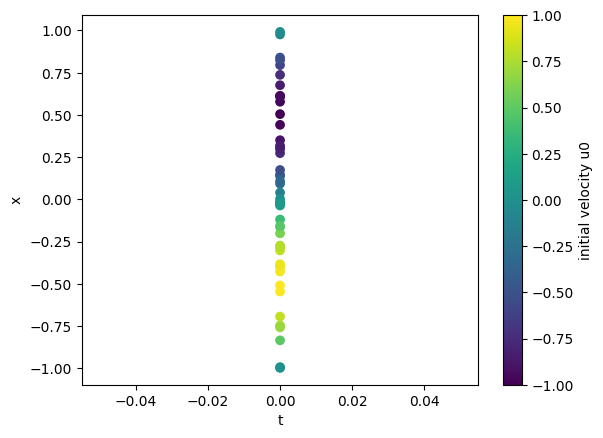

In [10]:
plot = pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
cb = pl.colorbar(plot)
pl.xlabel("t")
pl.ylabel("x")
cb.set_label("initial velocity u0"); # this tells about the fluid velocity

Figure 2 : This is the visual for the initial condition at t=0.

# get data at boundaries of x at random t's



In [11]:
t_b = tf.random.uniform((n_b, 1), tmin, tmax, dtype="float32")
x_b = xmin + (xmax - xmin) * tf.keras.backend.random_bernoulli((n_b, 1), 0.5, dtype="float32")
X_b = tf.concat([t_b, x_b], axis=1)
X_b

<tf.Tensor: shape=(50, 2), dtype=float32, numpy=
array([[ 0.88968754,  1.        ],
       [ 0.12354946, -1.        ],
       [ 0.7718717 , -1.        ],
       [ 0.6850728 ,  1.        ],
       [ 0.6442598 , -1.        ],
       [ 0.07745004, -1.        ],
       [ 0.75058556,  1.        ],
       [ 0.6250843 , -1.        ],
       [ 0.00772953, -1.        ],
       [ 0.55370283,  1.        ],
       [ 0.83894694,  1.        ],
       [ 0.43658102,  1.        ],
       [ 0.9566101 ,  1.        ],
       [ 0.7588576 , -1.        ],
       [ 0.8964343 , -1.        ],
       [ 0.44467843,  1.        ],
       [ 0.3243779 , -1.        ],
       [ 0.3443855 ,  1.        ],
       [ 0.91262174, -1.        ],
       [ 0.77731085, -1.        ],
       [ 0.899588  ,  1.        ],
       [ 0.50426483, -1.        ],
       [ 0.45032525,  1.        ],
       [ 0.5939442 ,  1.        ],
       [ 0.71862614, -1.        ],
       [ 0.91657436,  1.        ],
       [ 0.98180914, -1.        ],
      

# evaluate data at boundaries of x at random t's


In [12]:
u_b = fun_u_b(t_b, x_b)
u_b

<tf.Tensor: shape=(50, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

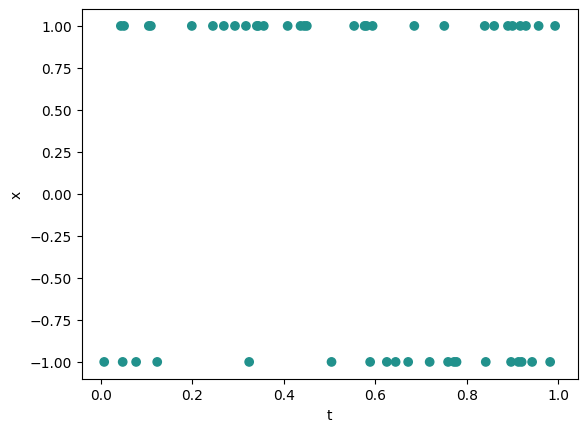

In [13]:
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

Figure 3: This figure is the representative of the predictions at boundaries for x =1 and x= -1.

# get points inside the space at random where the function will be predicted

In [14]:
t_r = tf.random.uniform((n_r, 1), tmin, tmax, dtype="float32")
x_r = tf.random.uniform((n_r, 1), xmin, xmax, dtype="float32")
X_r = tf.concat([t_r, x_r], axis=1)
X_r

<tf.Tensor: shape=(10000, 2), dtype=float32, numpy=
array([[ 0.48962688, -0.15719008],
       [ 0.5857923 ,  0.16138387],
       [ 0.36451697, -0.43461084],
       ...,
       [ 0.9338294 ,  0.9995079 ],
       [ 0.11166203, -0.28287673],
       [ 0.00506091,  0.7726338 ]], dtype=float32)>

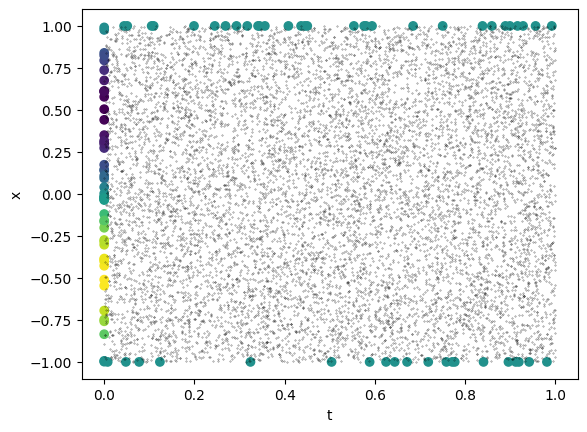

In [15]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c="k", marker='.', s=0.3, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

Figure 4: This is what the plot looks like with initial and boundary conditions and 10000 points confined inside of it, which we want to predict.

In [16]:
#put boundary conditionns together
X = tf.concat([X_0, X_b], axis=0)
y = tf.concat([u_0, u_b], axis=0)
X.shape, y.shape


(TensorShape([100, 2]), TensorShape([100, 1]))

In [17]:
input_shape = X.shape[1:]
input_shape

TensorShape([2])

# create the model with simple loss

In [18]:
nnmodel = tf.keras.Sequential()

#input layer with 2 neurons for 2 dimensions
nnmodel.add(tf.keras.layers.InputLayer(input_shape=2))

#8 hidden layers
for i in range(8):
  nnmodel.add(tf.keras.layers.Dense(units=30, activation="tanh"))

#output layer is 1D
nnmodel.add(tf.keras.layers.Dense(units=1))


In [19]:
optim = tf.keras.optimizers.Adam(learning_rate=1e-3)
def custom_loss(u_true, u_pred):
  mse = tf.reduce_mean(tf.square(u_true - u_pred)) #this is the L2 loss
  return mse

In [20]:
nnmodel.compile(loss=custom_loss, optimizer=optim)

## train the model

In [21]:
history = nnmodel.fit(X, y, epochs=1000)

Epoch 1/1000
4/4 [==============================] - 8s 7ms/step - loss: 0.2577
Epoch 2/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.2028
Epoch 3/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1894
Epoch 4/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1798
Epoch 5/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1779
Epoch 6/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1671
Epoch 7/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1607
Epoch 8/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1557
Epoch 9/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1413
Epoch 10/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1289
Epoch 11/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1193
Epoch 12/1000
4/4 [==============================] - 0s 6ms/step - loss: 0.1076
Epoch 13/1000
4/4 [==============================

Text(0, 0.5, 'loss')

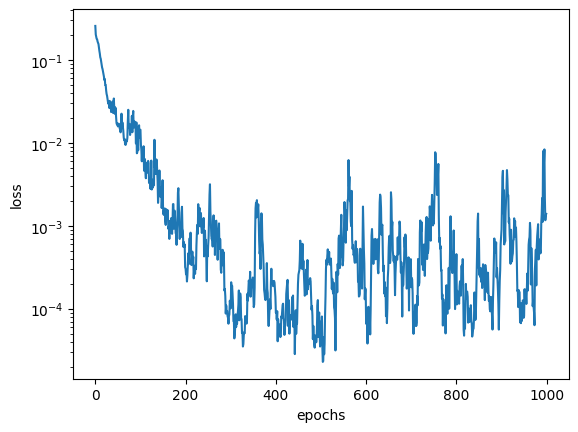

In [22]:
pl.semilogy(history.history["loss"])
pl.xlabel("epochs")
pl.ylabel("loss")

Figure 5: The loss is pretty noisy as we are missing the PDEs.

Noisy loss

## see the result

In [23]:
nnmodel.predict(tf.concat([t_r, x_r], axis=1))

313/313 [==============================] - 1s 3ms/step


array([[-0.02127955],
       [-0.03280493],
       [ 0.01107001],
       ...,
       [-0.00233475],
       [ 0.21552502],
       [-0.70981115]], dtype=float32)

313/313 [==============================] - 1s 3ms/step


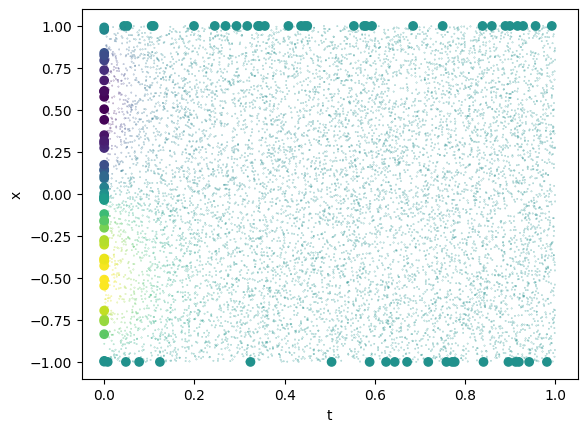

In [24]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c=nnmodel.predict(tf.concat([t_r, x_r], axis=1)), marker='.',
           s=0.2, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

Figure 6: The plot shows the predictions after running the neural network, and it's predicting zero as the top and the bottom says zero so it's averaging out everything. We dont have enough examples to train, so we expect this to fail.

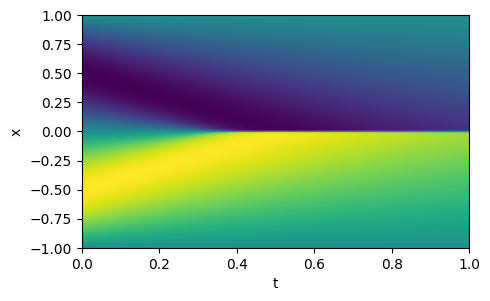

In [25]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
cb = ax.imshow(Z[::-1],extent=[0,1,-1,1], clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3);


Figure 7: The solution of Burger's equation, using to compare with our results.

show the accuracy for every point that you solved for

8/8 [==============================] - 0s 2ms/step


-1.2107658610401455

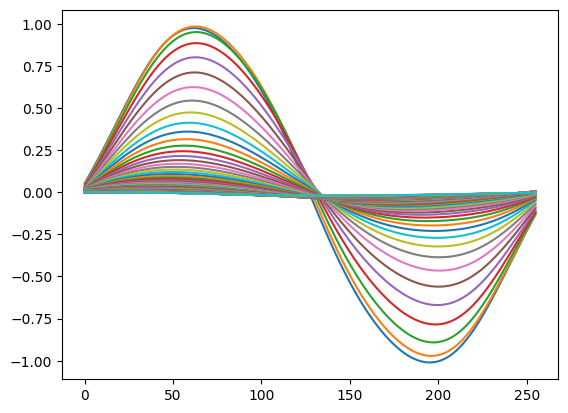

In [26]:
def L1accuracy(t, x, model):
  tmp_ = np.zeros((x.shape[0], 2), dtype="float32")
  tmp_[:,1] += x
  acc = 0
  for tt in range(t.shape[0]):
    tmp_[:,0] = t[tt]
    pl.plot(model.predict(tmp_))
    acc += (model.predict(tmp_) - Z[:,tt]).sum()


  return acc / np.prod(t.shape[0] * x.shape[0])
L1accuracy(t, x, nnmodel)

Figure 8 : The horizontal axis is x (elements) so, 0 corresponds to x = -1, the vetical is u, velocity and each of these lines represent differen time (the colors).

8/8 [==============================] - 0s 2ms/step


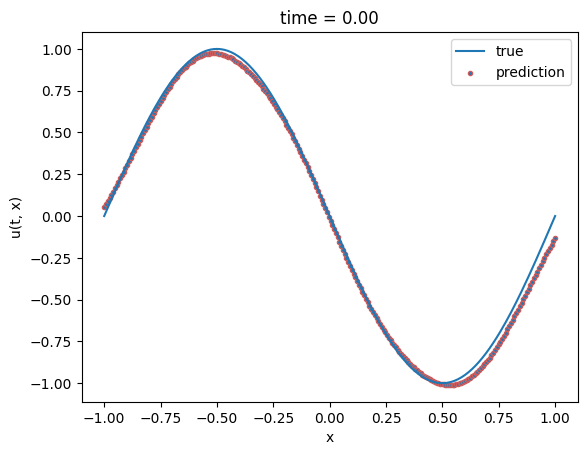

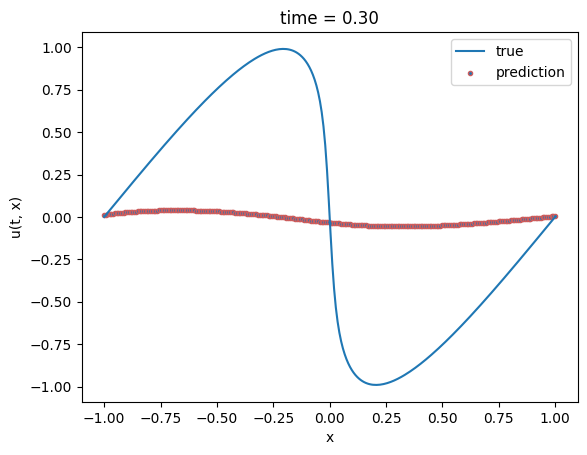

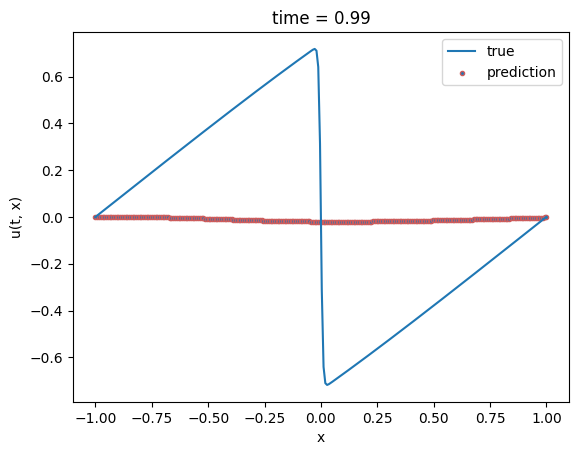

In [27]:
tmp_ = np.zeros((x.shape[0], 2), dtype="float32")
tmp_[:,1] += x
inds = [0, 30, -1]
for i in range(3):
  pl.figure()
  pl.title("time = %.2f"%t[inds[i]])
  pl.plot(x, Z[:,inds[i]], label="true")
  tmp_[:,0] = t[inds[i]]
  pl.scatter(x, nnmodel.predict(tmp_), marker='.', edgecolors="IndianRed",
             label="prediction")
  pl.xlabel("x")
  pl.ylabel("u(t, x)")
  pl.legend();


Figure 9: the plots show different values for fluid velocity over x at different times and clearly we can see the predictions are not correct with time.

# create the model with complete loss

In [28]:
def get_pde(model, X_r):

  with tf.GradientTape(persistent=True) as tape:
      t, x = X_r[:,0:1], X_r[:,1:2]
      tape.watch(t)
      tape.watch(x)
      u = model(tf.concat([t, x], axis=1))
      u_x = tape.gradient(u,x)
      #print(u_x)
  u_t = tape.gradient(u, t)
  u_xx = tape.gradient(u_x, x)

  del tape # to save some memory

  return u, u_t, u_x, u_xx


In [29]:
def customloss(model,X_r, X, y):
  u_pred = model(X)
  loss = custom_loss(y, u_pred)
  u_pred, u_t, u_x, u_xx = get_pde(model, X_r)
  pde = fun_res(u_pred, u_t, u_x, u_xx)
  loss += tf.reduce_mean(tf.square(pde))
  return loss

In [30]:
def get_grad(model, X_r, X, y):
    # model derivatives for backprop
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model.trainable_variables)

        # Define your loss function based on predicted values and PDE derivatives
        loss = customloss(model,X_r, X , y)

    # Compute gradients
    gradients = tape.gradient(loss, model.trainable_variables)

    # Clear the tape to save memory
    del tape

    return loss, gradients


## train the model

In [31]:
import copy

In [32]:
pinn = tf.keras.Sequential()

#input layer with 2 neurons for 2 dimensions
pinn.add(tf.keras.layers.InputLayer(input_shape= 2))
#hidden layers
for i in range(8):
  pinn.add(tf.keras.layers.Dense(units=10, activation = "tanh"))
#output layer is 1D
pinn.add(tf.keras.layers.Dense(units= 1)) #add activation to output


In [33]:
@tf.function
def train_step(model, X_r, X, y):

  loss, grad = get_grad(model, X_r, X, y)
  optim.apply_gradients(zip(grad, model.trainable_variables))
  return loss

optim = tf.keras.optimizers.Adam(learning_rate=0.005)
pinn.compile(loss=custom_loss, optimizer=optim) #change the loss and optimization

history = []
Nepochs = 5000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  #Output current loss after 50 iterates
  if i%50 == 0:
    print('It {:05d}: loss = {:10.8e}'.format(i,loss))



It 00000: loss = 3.36756825e-01
It 00050: loss = 1.16818875e-01
It 00100: loss = 7.75527507e-02
It 00150: loss = 6.66774213e-02
It 00200: loss = 6.08705990e-02
It 00250: loss = 5.74233010e-02
It 00300: loss = 5.40939644e-02
It 00350: loss = 5.09157479e-02
It 00400: loss = 6.66754991e-02
It 00450: loss = 4.36690710e-02
It 00500: loss = 6.33860976e-02
It 00550: loss = 4.63741943e-02
It 00600: loss = 2.77664121e-02
It 00650: loss = 3.68894041e-02
It 00700: loss = 2.27449164e-02
It 00750: loss = 3.41617204e-02
It 00800: loss = 1.87310949e-02
It 00850: loss = 1.59350485e-02
It 00900: loss = 2.07817927e-02
It 00950: loss = 1.47558087e-02
It 01000: loss = 2.88464166e-02
It 01050: loss = 1.00980606e-02
It 01100: loss = 8.27348325e-03
It 01150: loss = 8.00622720e-03
It 01200: loss = 6.25246949e-03
It 01250: loss = 2.61609014e-02
It 01300: loss = 5.24360966e-03
It 01350: loss = 4.35618684e-03
It 01400: loss = 6.42315764e-03
It 01450: loss = 3.86966299e-03
It 01500: loss = 3.40562896e-03
It 01550

313/313 [==============================] - 1s 3ms/step


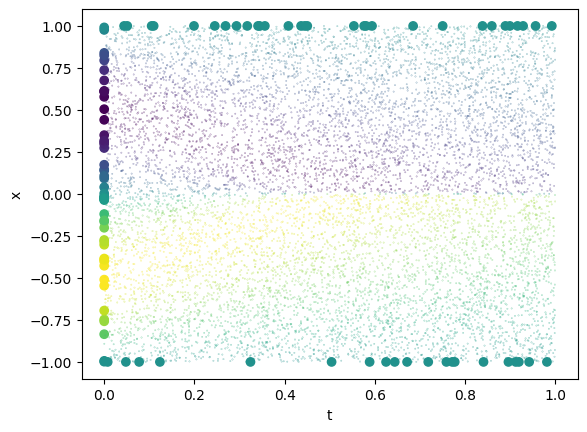

In [34]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)), marker='.',
           s=0.2, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

Figure 10: Now this is the result for the predictions of 10000 points, and i see it's predicting quite well, better than before.

313/313 [==============================] - 1s 2ms/step


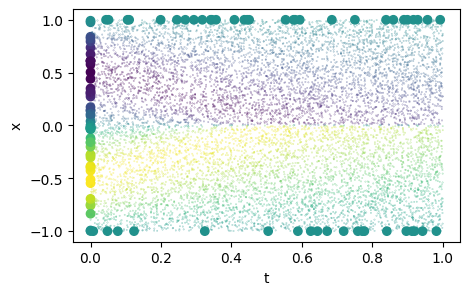

In [35]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)),
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");
ax.set_aspect(0.3);

Figure 11: Same as figure 10, better predictions.

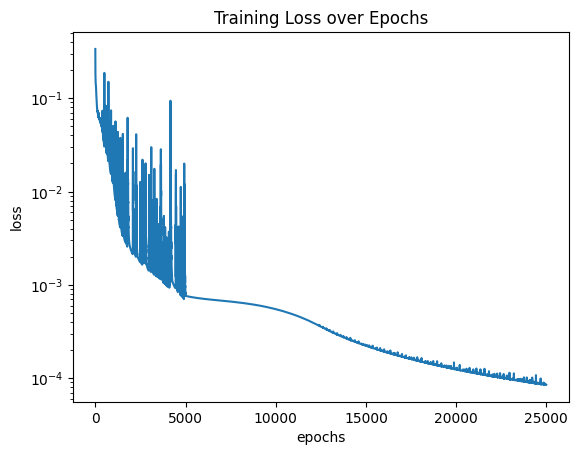

In [48]:
pl.semilogy(history)
pl.xlabel("epochs")
plt.title("Training Loss over Epochs")
pl.ylabel("loss");

Figure 12: The loss is still pretty noisy because we might need to train on more data.

8/8 [==============================] - 0s 2ms/step


-0.006531421933488523

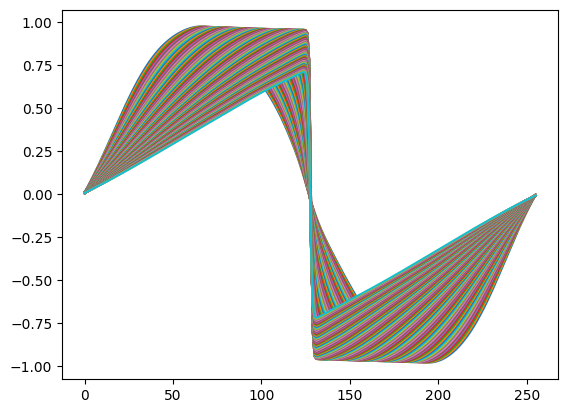

In [38]:
L1accuracy(t, x, pinn)

Figure 13: The plot of u vs. x over different times.

# adjust the learning rate and trin some more
the loss was awfully noisy

In [39]:
from tensorflow.keras.backend import set_value
set_value(pinn.optimizer.lr, 0.0001)

In [40]:
Nepochs = 10000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))


It 00000: loss = 8.01618909e-04
It 00050: loss = 7.58176786e-04
It 00100: loss = 7.54231121e-04
It 00150: loss = 7.50794949e-04
It 00200: loss = 7.47517566e-04
It 00250: loss = 7.44374993e-04
It 00300: loss = 7.41361815e-04
It 00350: loss = 7.38459406e-04
It 00400: loss = 7.35662004e-04
It 00450: loss = 7.32969143e-04
It 00500: loss = 7.30372907e-04
It 00550: loss = 7.27866136e-04
It 00600: loss = 7.25446502e-04
It 00650: loss = 7.23108882e-04
It 00700: loss = 7.20848562e-04
It 00750: loss = 7.18659139e-04
It 00800: loss = 7.16540148e-04
It 00850: loss = 7.14480469e-04
It 00900: loss = 7.12486391e-04
It 00950: loss = 7.10553606e-04
It 01000: loss = 7.08666630e-04
It 01050: loss = 7.06831226e-04
It 01100: loss = 7.05045182e-04
It 01150: loss = 7.03295635e-04
It 01200: loss = 7.01591722e-04
It 01250: loss = 6.99922792e-04
It 01300: loss = 6.98284828e-04
It 01350: loss = 6.96673407e-04
It 01400: loss = 6.95092254e-04
It 01450: loss = 6.93533686e-04
It 01500: loss = 6.91995258e-04
It 01550

Text(0, 0.5, 'loss')

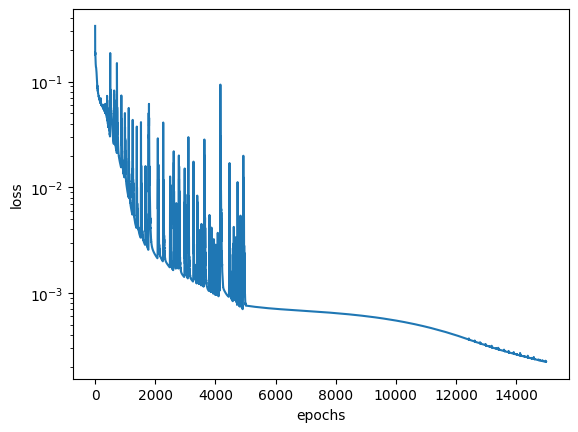

In [41]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss")

Figure 14: After training with complete loss the loss with epochs look pretty noisy in the start however these converge but still got some small spikes at the end.

313/313 [==============================] - 1s 2ms/step


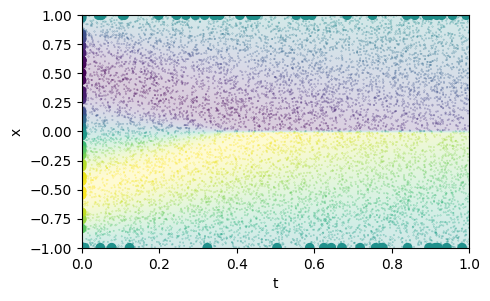

In [42]:
ax = pl.figure(figsize=(5,5)).add_subplot()
ax.imshow(Z[::-1],extent=[0,1,-1,1], alpha=0.2)
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)),
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3);

Figure 15: Even better predictions than before after incorporating pdes in the function and then training it with the NNs.

In [43]:
Nepochs = 10000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

It 00000: loss = 2.23482464e-04
It 00050: loss = 2.21463983e-04
It 00100: loss = 2.19424401e-04
It 00150: loss = 2.17743160e-04
It 00200: loss = 2.17593348e-04
It 00250: loss = 2.14507774e-04
It 00300: loss = 2.12935614e-04
It 00350: loss = 2.11363251e-04
It 00400: loss = 2.10621511e-04
It 00450: loss = 2.08361947e-04
It 00500: loss = 2.06865370e-04
It 00550: loss = 2.09173653e-04
It 00600: loss = 2.04051525e-04
It 00650: loss = 2.02647323e-04
It 00700: loss = 2.01147850e-04
It 00750: loss = 1.99748800e-04
It 00800: loss = 2.00168943e-04
It 00850: loss = 1.97027926e-04
It 00900: loss = 1.95670771e-04
It 00950: loss = 1.94358756e-04
It 01000: loss = 1.93264364e-04
It 01050: loss = 1.91856845e-04
It 01100: loss = 1.90452352e-04
It 01150: loss = 1.89168219e-04
It 01200: loss = 1.88075763e-04
It 01250: loss = 1.86788617e-04
It 01300: loss = 1.85493496e-04
It 01350: loss = 1.86396210e-04
It 01400: loss = 1.83175114e-04
It 01450: loss = 1.81943062e-04
It 01500: loss = 1.80769974e-04
It 01550

Text(0, 0.5, 'loss')

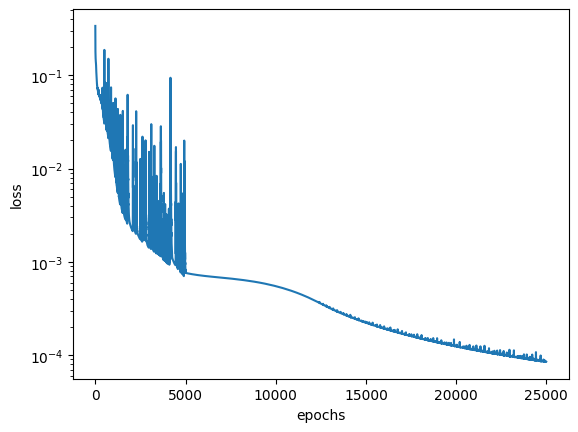

In [44]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss")

Figure 16: The loss over epochs is getting better now.

## final result

8/8 [==============================] - 0s 3ms/step


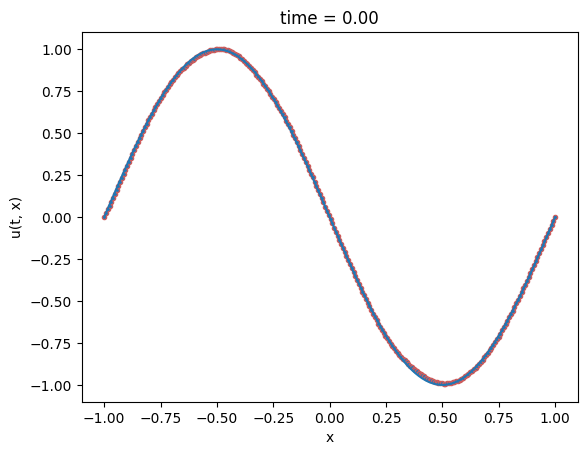

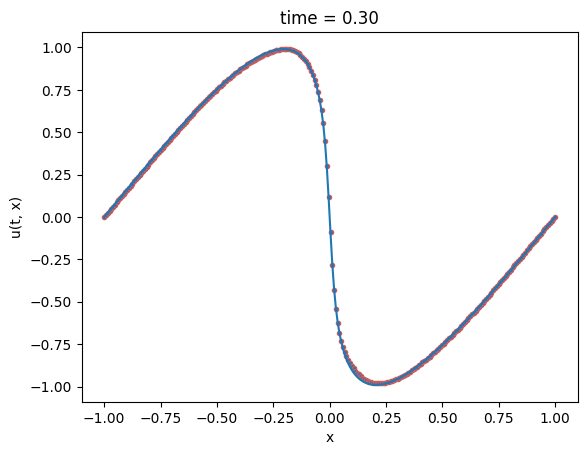

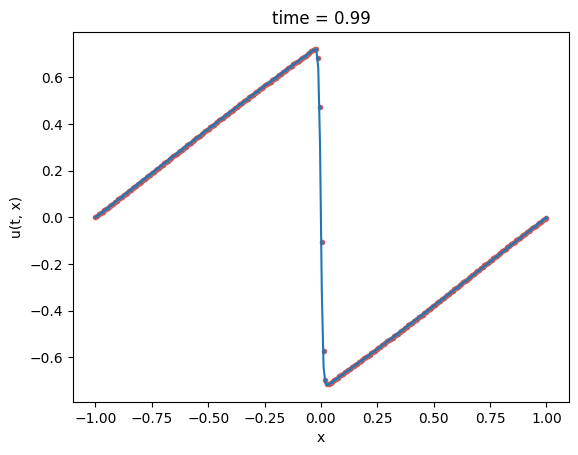

In [45]:
for i in range(3):
  pl.figure()
  pl.title("time = %.2f"%t[inds[i]])
  pl.plot(x, Z[:,inds[i]])
  tmp_[:,0] = t[inds[i]]
  pl.scatter(x, pinn.predict(tmp_), marker='.', edgecolors="IndianRed")
  pl.xlabel("x")
  pl.ylabel("u(t, x)");

Figure 17: Now the NN is predicting the fluid velocity with time accurately, with the addition of complete loss with pdes.

313/313 [==============================] - 1s 3ms/step


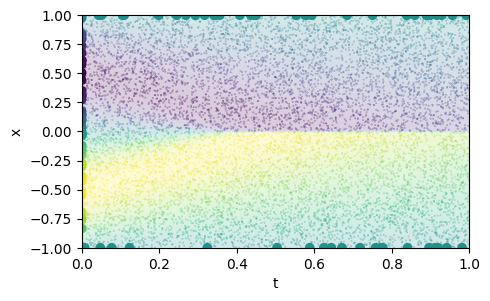

In [46]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
ax.imshow(Z[::-1], extent=[0,1,-1,1], alpha=0.2)
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)),
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3)
#pl.colorbar();

Figure 18: This plot shows the final visualisation of the solution of Burger's equation. When training the model with PDEs. we get better predictions for fluid velocity with respect to it's position in time t.

8/8 [==============================] - 0s 4ms/step


0.4275804859398145

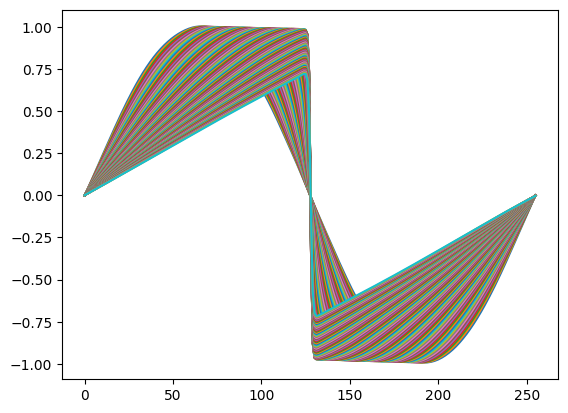

In [47]:
L1accuracy(t, x, pinn)

Figure 19:
The function L1accuracy calculates the L1 accuracy between the predictions made by the model and the true values Z across the time and space dimensions. The plot, visualizes the model's behavior over time, showcasing its predictions for different time steps across the input space.